# 3D Segmentation Tutorial
In the following tutorial you'll learn a bit about volumetric segmentation of medical images using a 3D convolutional neural network. Much of the code is borrowed from https://github.com/imlab-uiip/lung-segmentation-3d.

In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# NIfTI images
We can use the nibabel module to load NIfTI images and get the numpy representation.


In [2]:
img = nib.load('id001-128x128x64.nii.gz')
img_data=img.get_data()
print('The size of the 3D image is: {:d}x{:d}x{:d}'.format(img_data.shape[0],img_data.shape[1],img_data.shape[2]))

The size of the 3D image is: 128x128x64


# Visualizing slices from 3D image
Here's an example showing the saggital, transverse, and frontal planes of the lung.  

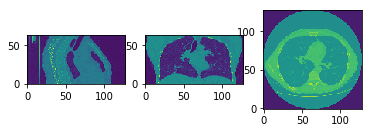

In [3]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower")

saggital = img_data[img_data.shape[0]//2, :, :]
frontal = img_data[:, img_data.shape[1]//2, :]
transverse = img_data[:, :, img_data.shape[2]//2]
show_slices([saggital, frontal, transverse])

# UNet3D model for 3D Segmentation
We're going to use the keras package to construct the UNet3D network model. The network consists of a number of encoding blocks (set of 3D convolution, non-linear, and 3D pooling layers) that successively build richer representations of the 3D input volume taking into account larger spatial context. The encoding blocks are followed a set of decoding blocks (upsampling layer followed by a set of 3D convolution and non-linear layers) that take the feature map from the previous block (either encoder or decoder block), upsample it, and concatenate the output of the corresponding encoder block that has the same spacial resolution. An example UNet3D architecture is shown below. 

 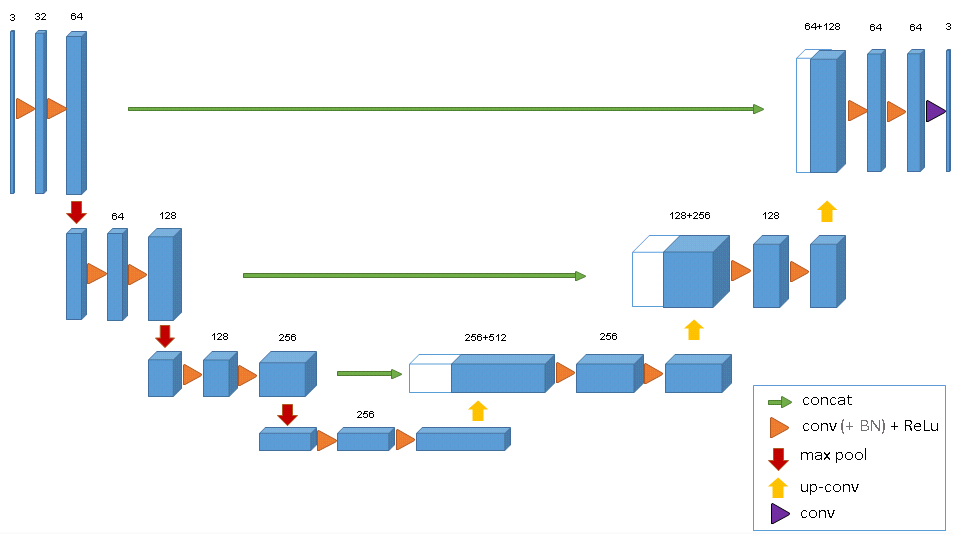

The following is a simple implementation of the Unet3D architecture that we will use to learn the 3D binary segmentation of the lung.

In [4]:
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution3D, MaxPooling3D, UpSampling3D
from keras.layers import Reshape, Activation
from keras.layers.normalization import BatchNormalization


def build_model(inp_shape, k_size=3):
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    data = Input(shape=inp_shape)
    conv1 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(data)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv4 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv6 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)

    conv7 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv8 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv8)

    conv9 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    up1 = UpSampling3D(size=(2, 2, 2))(conv9)
    conv10 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(up1)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    conv11 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    merged1 = concatenate([conv11, conv8], axis=merge_axis)
    conv12 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(merged1)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)

    up2 = UpSampling3D(size=(2, 2, 2))(conv12)
    conv13 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up2)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    conv14 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    merged2 = concatenate([conv14, conv6], axis=merge_axis)
    conv15 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged2)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)

    up3 = UpSampling3D(size=(2, 2, 2))(conv15)
    conv16 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up3)
    conv16 = BatchNormalization()(conv16)
    conv16 = Activation('relu')(conv16)
    conv17 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('relu')(conv17)
    merged3 = concatenate([conv17, conv4], axis=merge_axis)
    conv18 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged3)
    conv18 = BatchNormalization()(conv18)
    conv18 = Activation('relu')(conv18)

    up4 = UpSampling3D(size=(2, 2, 2))(conv18)
    conv19 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up4)
    conv19 = BatchNormalization()(conv19)
    conv19 = Activation('relu')(conv19)
    conv20 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv19)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation('relu')(conv20)
    merged4 = concatenate([conv20, conv2], axis=merge_axis)
    conv21 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged4)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation('relu')(conv21)

    conv22 = Convolution3D(padding='same', filters=2, kernel_size=k_size)(conv21)
    output = Reshape([-1, 2])(conv22)
    output = Activation('softmax')(output)
    output = Reshape(inp_shape[:-1] + (2,))(output)

    model = Model(data, output)
    return model


Using TensorFlow backend.


# Loading image data
The function below constructs the input, $\bf{X}$, to the network which consists of the 3D images of the lung concatenated with the $x$, $y$, and $z$ pixel coordinates. The network output is a binary 3D segmentation that is compared against the ground truth binary label, $\bf{y}$.

In [26]:
def loadDataGeneral(df, path):
    """
    This function loads data stored in nifti format. Data should already be of
    appropriate shape.
    
    Inputs:
    - df: Pandas dataframe with two columns: image filenames and ground truth filenames.
    - path: Path to folder containing filenames from df.
    - append_coords: Whether to append coordinate channels or not.
    Returns:
    - X: Array of 3D images with 1 or 4 channels depending on `append_coords`.
    - y: Array of 3D masks with 1 channel.
    """
    X, y = [], []
    for i, item in df.iterrows():
        img = nib.load(path + item[0]).get_data()
        mask = nib.load(path + item[1]).get_data()
        mask = np.clip(mask, 0, 255)
        cmask = (mask * 1. // 255)
        out = cmask
        X.append(img)
        y.append(out)
    X = np.expand_dims(X, -1)
    y = np.expand_dims(y, -1)
    y = np.concatenate((1 - y, y), -1)
    y = np.array(y)
    # Append coordinates as additional channels
#    n = X.shape[0]
#    inpShape = X.shape[1:]
#    xx = np.empty(inpShape)
#    for i in range(inpShape[1]):
#        xx[:, i, :, 0] = i
#    yy = np.empty(inpShape)
#    for i in range(inpShape[0]):
#        yy[i, :, :, 0] = i
#    zz = np.empty(inpShape)
#    for i in range(inpShape[2]):
#        zz[:, :, i, 0] = i
#    X = np.concatenate([X, np.array([xx] * n), np.array([yy] * n), np.array([zz] * n)], -1)

    print('### Dataset loaded')
    print('\t{}'.format(path))
    print( '\t{}\t{}'.format(X.shape, y.shape))
    print( '\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    return X, y


# Model training
We will use stochastic gradient descent (specifically the Adam update rule) to train the network we built earlier, to minimize the binary cross entropy loss $\frac{1}{N}\sum\limits_{i=1}^N(y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)$.



### Dataset loaded
	./
	(4, 128, 128, 64, 4)	(4, 128, 128, 64, 2)
	X:-3603.9-2204.6	y:-0.0-1.0

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 64, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 64, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64, 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64, 0           batch_normalization_1[0][0]      
_____________

Train on 3 samples, validate on 1 samples
Epoch 1/10
3/3 [==============================] - 23s 8s/step - loss: 0.5150 - acc: 0.7593 - val_loss: 1.7870 - val_acc: 0.8892
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 0.1535 - acc: 0.9338 - val_loss: 1.7509 - val_acc: 0.8740
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 0.0853 - acc: 0.9644 - val_loss: 1.5792 - val_acc: 0.8600
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.0796 - acc: 0.9632 - val_loss: 0.7452 - val_acc: 0.8770
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 0.0733 - acc: 0.9655 - val_loss: 0.6429 - val_acc: 0.8554
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 0.0698 - acc: 0.9665 - val_loss: 0.8797 - val_acc: 0.8353
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.0702 - acc: 0.9658 - val_loss: 1.1861 - val_acc: 0.8112
Epoch 8/10
3/3 [==============================] - 5s 2s/step - loss:

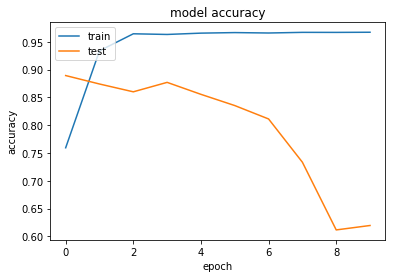

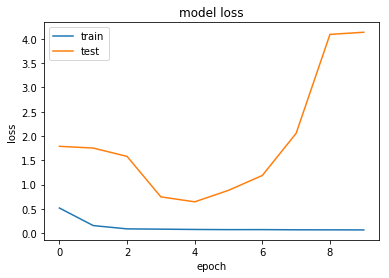

In [17]:
from keras.callbacks import ModelCheckpoint
# Path to csv-file. File should contain X-ray filenames as first column,
# mask filenames as second column.
csv_path = './idx-train.csv'
# Path to the folder with images. Images will be read from path + path_from_csv
path = csv_path[:csv_path.rfind('/')] + '/'

df = pd.read_csv(csv_path)
# Shuffle rows in dataframe. Random state is set for reproducibility.
df = df.sample(frac=1, random_state=23)

# Load training data
X, y = loadDataGeneral(df, path)

# Build model
inp_shape = X[0].shape
model = build_model(inp_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

##########################################################################################
checkpointer = ModelCheckpoint('model3.{epoch:03d}.hdf5', period=5)

history=model.fit(X, y, batch_size=1, epochs=10, callbacks=[checkpointer], validation_split=0.2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Segmentation task accuracy
In order to evaluate the quality of the predicted binary segmentation, with respect to the ground truth segmentation,  we will use the Intersection over Union accuracy, otherwise known as the Jaccard index. If $P$ and $G$ are the sets of foreground pixels in the predicted and ground truth segmentation respectively, then the Intersection over Union accuracy can be computed as, $\frac{|P \cap G|}{|P\cup G|}$.

In [6]:
def IoU(y_true, y_pred):
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

# Evaluating on held out images

### Dataset loaded
	./
	(4, 128, 128, 64, 1)	(4, 128, 128, 64, 2)
	X:-3603.9-2204.6	y:-0.0-1.0



/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/pylon5/ac5616p/pyadolla/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWa

id001-128x128x64.nii.gz 0.7564289644283904
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
id002-128x128x64.nii.gz 0.632878241456294
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
id003-128x128x64.nii.gz 0.7684436870065373
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
id004-128x128x64.nii.gz 0.7504531917648583
(128, 128, 64)
(128, 128, 64)
(128, 128, 64)
Mean IoU:
0.72705102116402


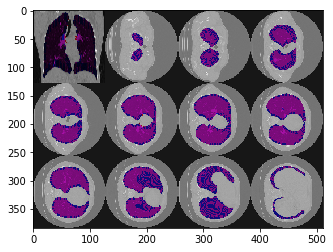

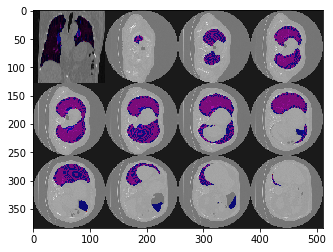

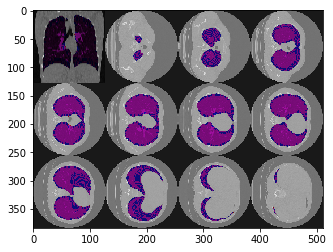

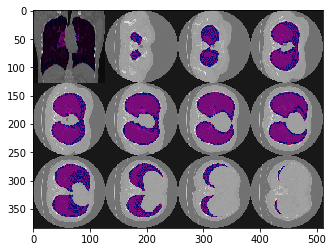

In [28]:
from scipy.misc import imresize
from skimage.color import hsv2rgb, rgb2hsv, gray2rgb
from skimage import io, exposure
from keras.models import load_model

plt.ioff()
def saggital(img):
    print(img.shape)
    """Extracts midle layer in saggital axis and rotates it appropriately."""
    return img[:, img.shape[1] // 2, ::-1].T

img_size = 128


# Path to csv-file. File should contain X-ray filenames as first column,
# mask filenames as second column.
csv_val_path = './idx-val.csv'
# Path to the folder with images. Images will be read from path + path_from_csv
val_path = csv_val_path[:csv_val_path.rfind('/')] + '/'

df_val = pd.read_csv(csv_val_path)

# Load test data
append_coords = True 
Xval, yval = loadDataGeneral(df_val, val_path)

n_val = Xval.shape[0]
inpShape_val = Xval.shape[1:]

model = load_model('trained_model.hdf5')
# Predict on test data
pred = model.predict(Xval, batch_size=1)[..., 1]

# Compute scores and visualize
ious = np.zeros(n_val)
for i in range(n_val):
    gt = yval[i, :, :, :, 1] > 0.5 # ground truth binary mask
    pr = pred[i] > 0.5 # binary prediction

    # Compute scores
    ious[i] = IoU(gt, pr)
    print(df_val.ix[i]['path'], ious[i])

    # Rescaling images to be within [0, 1].
    t_img = exposure.rescale_intensity(nib.load(val_path + df_val.ix[i]['path']).get_data(), out_range=(0, 1))
    # Creating 3x4 table previews
    lungs = np.zeros((img_size * 3, img_size * 4)) # Slices from original grayscale image
    mask = np.zeros((img_size * 3, img_size * 4)) # Slices from predicted mask
    gt_mask = np.zeros((img_size * 3, img_size * 4)) # Slices from ground truth mask
    # Fill [0, 0] cell with saggital view of lungs
    lungs[:img_size, :img_size] = imresize(saggital(t_img), [img_size, img_size]) * 1. / 256
    mask[:img_size, :img_size][imresize(saggital(pred[i]), [img_size, img_size]) > 128] = 1
    gt_mask[:img_size, :img_size][imresize(saggital(yval[i][..., 1]), [img_size, img_size]) > 128] = 1
    # Fill the rest of the cells with 11 slices in z direction
    for k in range(1, 12):
        yy, xx = k // 4, k % 4 # Cell coordinates
        zz = int(t_img.shape[-1] * (k * 1. / 12)) # z coordinate of a slice
        lungs[yy * img_size: (yy + 1) * img_size, xx * img_size: (xx + 1) * img_size] = t_img[:, :, -zz]
        mask[yy * img_size: (yy + 1) * img_size, xx * img_size: (xx + 1) * img_size][pr[:, :, -zz]] = 1
        gt_mask[yy * img_size: (yy + 1) * img_size, xx * img_size: (xx + 1) * img_size][gt[:, :, -zz]] = 1
    # Combining masks to get a pretty picture
    prv = rgb2hsv(gray2rgb(lungs))
    mask_hsv = rgb2hsv(np.dstack([gt_mask, np.zeros_like(mask), mask]))
    prv[..., 0] = mask_hsv[..., 0]
    prv[..., 1] = mask_hsv[..., 1] * 0.9
    plt.figure()
    plt.imshow(hsv2rgb(prv))
#    io.imsave('Demo/Predictions/' + df.ix[i]['path'] + '-preview2.png', hsv2rgb(prv))
#    io.imsave('Demo/Predictions/' + df.ix[i]['path'] + '-mask2.png', np.dstack([gt_mask, mask, mask]))


print( 'Mean IoU:')
print( ious.mean())

